In [ ]:
from google.colab import files
uploaded = files.upload()

Saving face_mask.zip to face_mask.zip


##Loading dataset


In [ ]:
!unzip face_mask.zip

Archive:  face_mask.zip
   creating: face_mask/
  inflating: face_mask/desktop.ini   
   creating: face_mask/without_mask/
  inflating: face_mask/without_mask/0.jpg  
  inflating: face_mask/without_mask/1.jpg  
  inflating: face_mask/without_mask/10.jpg  
  inflating: face_mask/without_mask/100.jpg  
  inflating: face_mask/without_mask/101.jpg  
  inflating: face_mask/without_mask/102.jpg  
  inflating: face_mask/without_mask/104.jpg  
  inflating: face_mask/without_mask/105.jpg  
  inflating: face_mask/without_mask/106.jpg  
  inflating: face_mask/without_mask/107.jpg  
  inflating: face_mask/without_mask/108.jpg  
  inflating: face_mask/without_mask/109.jpg  
  inflating: face_mask/without_mask/11.jpg  
  inflating: face_mask/without_mask/110.jpg  
  inflating: face_mask/without_mask/111.jpg  
  inflating: face_mask/without_mask/112.jpg  
  inflating: face_mask/without_mask/114.jpg  
  inflating: face_mask/without_mask/115.jpg  
  inflating: face_mask/without_mask/116.jpg  
  inflati

##Importing Libraries

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

##Preparing Data

In [ ]:
imagePaths = list(paths.list_images("face_mask"))
len(imagePaths)

1376

In [ ]:
### Data processing can also be done as follows.
'''import cv2
X_data =[]
for file in imagePaths:
    face = cv2.imread(file,cv2.IMREAD_COLOR)
    face = cv2.resize(face, (224,224) )
    X_data.append(face)
X_data=np.array(X_data)
X_data = X_data.astype('float32')
X_data /= 255
X_data[1]'''

"import cv2\nX_data =[]\nfor file in imagePaths:\n    face = cv2.imread(file,cv2.IMREAD_COLOR)\n    face = cv2.resize(face, (224,224) )\n    X_data.append(face)\nX_data=np.array(X_data)\nX_data = X_data.astype('float32')\nX_data /= 255\nX_data[1]"

In [ ]:
data = []
labels = []
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]  #-2 means you are fetching the 2nd value after separating the path from the end
  image = image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
data.shape

(1376, 224, 224, 3)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = np.array(labels)
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


##Training data

In [ ]:
# partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

##Model Architecture

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

##Training, Prediction and Evaluation of Model

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 54s 1s/step - loss: 0.5343 - accuracy: 0.7903 - val_loss: 0.2736 - val_accuracy: 0.9855
Epoch 2/20
34/34 [==============================] - 47s 1s/step - loss: 0.2224 - accuracy: 0.9644 - val_loss: 0.1191 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 47s 1s/step - loss: 0.1214 - accuracy: 0.9850 - val_loss: 0.0725 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 49s 1s/step - loss: 0.0872 - accuracy: 0.9825 - val_loss: 0.0525 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 47s 1s/step - loss: 0.0706 - accuracy: 0.9888 - val_loss: 0.0407 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 48s 1s/step - loss: 0.0538 - accuracy: 0.9906 - val_loss: 0.0330 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 47s 1s/step - loss: 0.0444 - accuracy: 0.9925 - val_loss: 0.0277 - val_accuracy: 0.9964
Epoch 8/20
34/34 [==

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



##Visualization and Saving Model

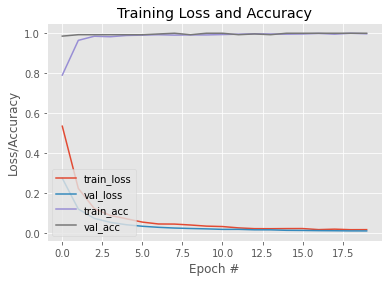

In [ ]:
model.save("MaskModel.h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

##Detecting from Image

In [ ]:
#uploading image
from google.colab import files
uploaded = files.upload()

Saving S.png to S.png


No Mask: 95.56%


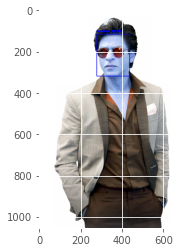

In [ ]:
import cv2
from tensorflow.keras.models import load_model
net = cv2.dnn.readNet("/content/prototxt.txt", "/content/res10_300x300_ssd_iter_140000.caffemodel")
model = load_model('/content/MaskModel.h5')

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("S.png")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
  confidence = detections[0, 0, i, 2]
  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
    (mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
    cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
plt.imshow(image)
print(label)

Mask: 99.91%


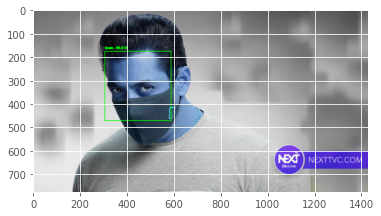

In [ ]:
import cv2
from tensorflow.keras.models import load_model
net = cv2.dnn.readNet("/content/prototxt.txt", "/content/res10_300x300_ssd_iter_140000.caffemodel")
model = load_model('/content/MaskModel.h5')

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("SA.png")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
  confidence = detections[0, 0, i, 2]
  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
    (mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
    cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
plt.imshow(image)
print(label)

##Detecting Realtime

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
      (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    for i in range(0, detections.shape[2]):
      # extract the confidence (i.e., probability) associated with
      # the detection
      confidence = detections[0, 0, i, 2]
      if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)

        # add the face and bounding boxes to their respective
        # lists
        faces.append(face)
        locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
      # for faster inference we'll make batch predictions on *all*
      # faces at the same time rather than one-by-one predictions
      # in the above `for` loop
      faces = np.array(faces, dtype="float32")
      preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

In [ ]:
from imutils.video import VideoStream
import time
import imutils
faceNet = cv2.dnn.readNet("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

# load the face mask detector model from disk
maskNet = load_model('MaskModel.h5')

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()